### Question 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
aspect_ratio = (12,8)

In [2]:
# Load data from Prices.csv
dfPrices = pd.read_csv('Prices.csv', index_col=0, parse_dates=True)


In [3]:
def calcSummaryStatistics(df, annualization_factor=260, print_Screen=True, percent_format_string="{:.2%}"):
    cumReturns = df.cumsum()
    underWaterCurve = cumReturns.fillna(0) - np.maximum.accumulate(cumReturns.fillna(0))

    summary_stats_new = pd.DataFrame([annualization_factor*df.mean(),
                              np.sqrt(annualization_factor)*df.std(),
                             df.mean() / df.std() * np.sqrt(annualization_factor),
                              underWaterCurve.min(axis=0),
                              (df.dropna() >= 0).sum() / df.dropna().shape[0]],
                             index=['Average Annual Return', 'Annual Risk', 'Sharpe Ratio', 'maxDD', 'Success Ratio'])
    
    index_slice = ['Average Annual Return', 'Annual Risk', 'Success Ratio','maxDD']
    print_pct_data(df=summary_stats_new,format_spec=percent_format_string,index_slice=index_slice)

In [4]:
def print_pct_data(df, format_spec="{:.4%}", na_rep="NaN", index_slice=None):
    # If index_slice is provided, format only the specified subset
    if index_slice is not None:
        # Exclude the rows specified in index_slice
        unformatted_data = df.drop(index=index_slice)
        formatted_data = df.loc[index_slice].style.format(format_spec, na_rep=na_rep)
    else:
        formatted_data = df.style.format(format_spec, na_rep=na_rep)
        unformatted_data = pd.DataFrame()

    # Display formatted and unformatted data
    display(formatted_data)
    display(unformatted_data)
    # return formatted_data

### Question 2

#### Moving Average Crossover

In [5]:
# defining the new function with the appropriate arguments to take in abs
def movingAverageCrossover(dataFrame, fastWindow, slowWindow):
    # checking that the inputted column from the dataframe is just 1 otherwise raising an error
    if len(dataFrame.columns) != 1:
        raise ValueError("Input dataFrame should have only one column")

    # copying the dataframe so as to not modify the original
    instrument = dataFrame.columns[0]
    data = dataFrame.copy()

    # Calculate fast and slow moving averages
    data.loc[:, 'FastSMA'] = data[instrument].rolling(fastWindow).mean()
    data.loc[:, 'SlowSMA'] = data[instrument].rolling(slowWindow).mean()

    # Dropping NAs
    data.style.format(na_rep='NaN')
    data.dropna(inplace=True)

    # Implement "go flat" strategy
    data.loc[:, 'Position_f'] = np.where(data['FastSMA'] > data['SlowSMA'], 1, 0)
    data.loc[:, instrument + '-BMK'] = np.log(data[instrument] / data[instrument].shift(1))
    data.loc[:, instrument + '-MAFlat'] = data['Position_f'].shift(1) * data[instrument + '-BMK']

    # Implement "go short" strategy
    data.loc[:, 'Position_s'] = np.where(data['FastSMA'] > data['SlowSMA'], 1, -1)
    data.loc[:, instrument + '-MAShort'] = data['Position_s'].shift(1) * data[instrument + '-BMK']

    # returning the relevant columns
    return data[[instrument + "-BMK", instrument + "-MAFlat", instrument + "-MAShort"]]

# List of stock symbols
stock_symbols = ['AAPL', 'EXC', 'GE', 'INTC', 'PFE', 'SPY']

# Dictionary to store optimal values
optimal_values = {}

# Comprehensive DataFrame to store Sharpe ratios for each stock using optimal windows of other stocks
comprehensive_df = pd.DataFrame()

# Iterate through stocks
for symbol in stock_symbols:
    # Extract closing prices
    df_stock = dfPrices[[symbol]].copy()

    # Initialize variables to store optimal values
    max_flat_sharpe = -float('inf')
    optimal_flat_window = None
    optimal_flat_slow_window = None

    max_short_sharpe = -float('inf')
    optimal_short_window = None
    optimal_short_slow_window = None

    # Iterate through window combinations
    for fast_window in range(5, 110):
        for slow_window in range(50, 500, 5):
            # Ensure fast window is less than slow window
            if fast_window < slow_window:
                # Run the function
                returns_df = movingAverageCrossover(df_stock.copy(), fast_window, slow_window)

                # Calculate Sharpe ratios
                flat_sharpe = returns_df[symbol + '-MAFlat'].mean() / returns_df[symbol + '-MAFlat'].std() * np.sqrt(260)
                short_sharpe = returns_df[symbol + '-MAShort'].mean() / returns_df[symbol + '-MAShort'].std() * np.sqrt(260)

                # Update optimal values for 'go flat' strategy
                if flat_sharpe > max_flat_sharpe:
                    max_flat_sharpe = flat_sharpe
                    optimal_flat_window = fast_window
                    optimal_flat_slow_window = slow_window

                # Update optimal values for 'go short' strategy
                if short_sharpe > max_short_sharpe:
                    max_short_sharpe = short_sharpe
                    optimal_short_window = fast_window
                    optimal_short_slow_window = slow_window

    # Store optimal values for each stock
    optimal_values[symbol] = {
        'OptimalFlatSharpe': max_flat_sharpe,
        'OptimalFlatWindow': optimal_flat_window,
        'OptimalFlatSlowWindow': optimal_flat_slow_window,
        'OptimalShortSharpe': max_short_sharpe,
        'OptimalShortWindow': optimal_short_window,
        'OptimalShortSlowWindow': optimal_short_slow_window,
    }

# Initialize an empty list to store DataFrames
comprehensive_dfs = []

# Iterate through stocks again to calculate Sharpe ratios using optimal windows of other stocks
for symbol in stock_symbols:
    # Extract closing prices
    df_stock = dfPrices[[symbol]].copy()

    # Initialize a list to store dictionaries for results
    results_list = []

    # Iterate through other stocks
    for other_symbol in stock_symbols:
        if other_symbol != symbol:
            # Run the function using optimal windows of the other stock
            returns_df_other = movingAverageCrossover(df_stock.copy(), optimal_values[other_symbol]['OptimalFlatWindow'],
                                                       optimal_values[other_symbol]['OptimalFlatSlowWindow'])

            # Calculate Sharpe ratios for 'go flat' strategy
            flat_sharpe_other = returns_df_other[symbol + '-MAFlat'].mean() / returns_df_other[symbol + '-MAFlat'].std() * np.sqrt(260)

            # Calculate Sharpe ratios for 'go short' strategy
            short_sharpe_other = returns_df_other[symbol + '-MAShort'].mean() / returns_df_other[symbol + '-MAShort'].std() * np.sqrt(260)

            # Append results to the list as a dictionary
            results_list.append({
                'Stock': symbol,
                'OtherStock': other_symbol,
                'OptimalFlatSharpeOther': flat_sharpe_other,
                'OptimalShortSharpeOther': short_sharpe_other,
            })

    # Convert the list of dictionaries to a DataFrame
    df_results = pd.DataFrame(results_list)

    # Append the DataFrame for the current stock to the list
    comprehensive_dfs.append(df_results)

# Concatenate all DataFrames in the list into a single comprehensive DataFrame
comprehensive_df = pd.concat(comprehensive_dfs, ignore_index=True)

# Print optimal values for each stock
for symbol, values in optimal_values.items():
    print(f"\nOptimal values for {symbol}:")
    print("Optimal 'go flat' strategy:")
    print("Max Sharpe Ratio:", values['OptimalFlatSharpe'])
    print("Optimal Fast Window:", values['OptimalFlatWindow'])
    print("Optimal Slow Window:", values['OptimalFlatSlowWindow'])

    print("\nOptimal 'go short' strategy:")
    print("Max Sharpe Ratio:", values['OptimalShortSharpe'])
    print("Optimal Fast Window:", values['OptimalShortWindow'])
    print("Optimal Slow Window:", values['OptimalShortSlowWindow'])

# Print comprehensive DataFrame
print("\nComprehensive DataFrame:")
print(comprehensive_df)


Optimal values for AAPL:
Optimal 'go flat' strategy:
Max Sharpe Ratio: 1.0125145882146425
Optimal Fast Window: 11
Optimal Slow Window: 220

Optimal 'go short' strategy:
Max Sharpe Ratio: 0.8220107196692458
Optimal Fast Window: 53
Optimal Slow Window: 55

Optimal values for EXC:
Optimal 'go flat' strategy:
Max Sharpe Ratio: 0.4117807228079647
Optimal Fast Window: 23
Optimal Slow Window: 50

Optimal 'go short' strategy:
Max Sharpe Ratio: 0.41841996288691075
Optimal Fast Window: 34
Optimal Slow Window: 365

Optimal values for GE:
Optimal 'go flat' strategy:
Max Sharpe Ratio: 0.24755182316017493
Optimal Fast Window: 96
Optimal Slow Window: 100

Optimal 'go short' strategy:
Max Sharpe Ratio: 0.5894201859949351
Optimal Fast Window: 96
Optimal Slow Window: 100

Optimal values for INTC:
Optimal 'go flat' strategy:
Max Sharpe Ratio: 0.2052169871937377
Optimal Fast Window: 63
Optimal Slow Window: 215

Optimal 'go short' strategy:
Max Sharpe Ratio: 0.26444251195783436
Optimal Fast Window: 68
Opt

##### Income

In [6]:
# List of stock symbols
income_symbols = ['FBNDX', 'VBTIX']

# Dictionary to store optimal values
optimal_values = {}

# Comprehensive DataFrame to store Sharpe ratios for each stock using optimal windows of other stocks
comprehensive_df = pd.DataFrame()

# Iterate through stocks
for symbol in income_symbols:
    # Extract closing prices
    df_stock = dfPrices[[symbol]].copy()

    # Initialize variables to store optimal values
    max_flat_sharpe = -float('inf')
    optimal_flat_window = None
    optimal_flat_slow_window = None

    max_short_sharpe = -float('inf')
    optimal_short_window = None
    optimal_short_slow_window = None

    # Iterate through window combinations
    for fast_window in range(5, 110):
        for slow_window in range(50, 500, 5):
            # Ensure fast window is less than slow window
            if fast_window < slow_window:
                # Run the function
                returns_df = movingAverageCrossover(df_stock.copy(), fast_window, slow_window)

                # Calculate Sharpe ratios
                flat_sharpe = returns_df[symbol + '-MAFlat'].mean() / returns_df[symbol + '-MAFlat'].std() * np.sqrt(260)
                short_sharpe = returns_df[symbol + '-MAShort'].mean() / returns_df[symbol + '-MAShort'].std() * np.sqrt(260)

                # Update optimal values for 'go flat' strategy
                if flat_sharpe > max_flat_sharpe:
                    max_flat_sharpe = flat_sharpe
                    optimal_flat_window = fast_window
                    optimal_flat_slow_window = slow_window

                # Update optimal values for 'go short' strategy
                if short_sharpe > max_short_sharpe:
                    max_short_sharpe = short_sharpe
                    optimal_short_window = fast_window
                    optimal_short_slow_window = slow_window

    # Store optimal values for each stock
    optimal_values[symbol] = {
        'OptimalFlatSharpe': max_flat_sharpe,
        'OptimalFlatWindow': optimal_flat_window,
        'OptimalFlatSlowWindow': optimal_flat_slow_window,
        'OptimalShortSharpe': max_short_sharpe,
        'OptimalShortWindow': optimal_short_window,
        'OptimalShortSlowWindow': optimal_short_slow_window,
    }

# Initialize an empty list to store DataFrames
comprehensive_dfs = []

# Iterate through stocks again to calculate Sharpe ratios using optimal windows of other stocks
for symbol in income_symbols:
    # Extract closing prices
    df_stock = dfPrices[[symbol]].copy()

    # Initialize a list to store dictionaries for results
    results_list = []

    # Iterate through other stocks
    for other_symbol in income_symbols:
        if other_symbol != symbol:
            # Run the function using optimal windows of the other stock
            returns_df_other = movingAverageCrossover(df_stock.copy(), optimal_values[other_symbol]['OptimalFlatWindow'],
                                                       optimal_values[other_symbol]['OptimalFlatSlowWindow'])

            # Calculate Sharpe ratios for 'go flat' strategy
            flat_sharpe_other = returns_df_other[symbol + '-MAFlat'].mean() / returns_df_other[symbol + '-MAFlat'].std() * np.sqrt(260)

            # Calculate Sharpe ratios for 'go short' strategy
            short_sharpe_other = returns_df_other[symbol + '-MAShort'].mean() / returns_df_other[symbol + '-MAShort'].std() * np.sqrt(260)

            # Append results to the list as a dictionary
            results_list.append({
                'Income': symbol,
                'OtherIncome': other_symbol,
                'OptimalFlatSharpeOther': flat_sharpe_other,
                'OptimalShortSharpeOther': short_sharpe_other,
            })

    # Convert the list of dictionaries to a DataFrame
    df_results = pd.DataFrame(results_list)

    # Append the DataFrame for the current stock to the list
    comprehensive_dfs.append(df_results)

# Concatenate all DataFrames in the list into a single comprehensive DataFrame
comprehensive_df = pd.concat(comprehensive_dfs, ignore_index=True)

# Print optimal values for each stock
for symbol, values in optimal_values.items():
    print(f"\nOptimal values for {symbol}:")
    print("Optimal 'go flat' strategy:")
    print("Max Sharpe Ratio:", values['OptimalFlatSharpe'])
    print("Optimal Fast Window:", values['OptimalFlatWindow'])
    print("Optimal Slow Window:", values['OptimalFlatSlowWindow'])

    print("\nOptimal 'go short' strategy:")
    print("Max Sharpe Ratio:", values['OptimalShortSharpe'])
    print("Optimal Fast Window:", values['OptimalShortWindow'])
    print("Optimal Slow Window:", values['OptimalShortSlowWindow'])

# Print comprehensive DataFrame
print("\nComprehensive DataFrame:")
print(comprehensive_df)


Optimal values for FBNDX:
Optimal 'go flat' strategy:
Max Sharpe Ratio: 0.5942553398824925
Optimal Fast Window: 73
Optimal Slow Window: 80

Optimal 'go short' strategy:
Max Sharpe Ratio: 0.6945634126094484
Optimal Fast Window: 73
Optimal Slow Window: 80

Optimal values for VBTIX:
Optimal 'go flat' strategy:
Max Sharpe Ratio: 0.30374049270271836
Optimal Fast Window: 70
Optimal Slow Window: 90

Optimal 'go short' strategy:
Max Sharpe Ratio: 0.3102792368626982
Optimal Fast Window: 74
Optimal Slow Window: 75

Comprehensive DataFrame:
  Income OtherIncome  OptimalFlatSharpeOther  OptimalShortSharpeOther
0  FBNDX       VBTIX                0.424794                 0.425127
1  VBTIX       FBNDX                0.137733                 0.083303


##### Commodity

In [7]:
# List of stock symbols
commodity_symbols = ['SPGSCI', 'XPT']

# Dictionary to store optimal values
optimal_values = {}

# Comprehensive DataFrame to store Sharpe ratios for each stock using optimal windows of other stocks
comprehensive_df = pd.DataFrame()

# Iterate through stocks
for symbol in commodity_symbols:
    # Extract closing prices
    df_stock = dfPrices[[symbol]].copy()

    # Initialize variables to store optimal values
    max_flat_sharpe = -float('inf')
    optimal_flat_window = None
    optimal_flat_slow_window = None

    max_short_sharpe = -float('inf')
    optimal_short_window = None
    optimal_short_slow_window = None

    # Iterate through window combinations
    for fast_window in range(5, 110):
        for slow_window in range(50, 500, 5):
            # Ensure fast window is less than slow window
            if fast_window < slow_window:
                # Run the function
                returns_df = movingAverageCrossover(df_stock.copy(), fast_window, slow_window)

                # Calculate Sharpe ratios
                flat_sharpe = returns_df[symbol + '-MAFlat'].mean() / returns_df[symbol + '-MAFlat'].std() * np.sqrt(260)
                short_sharpe = returns_df[symbol + '-MAShort'].mean() / returns_df[symbol + '-MAShort'].std() * np.sqrt(260)

                # Update optimal values for 'go flat' strategy
                if flat_sharpe > max_flat_sharpe:
                    max_flat_sharpe = flat_sharpe
                    optimal_flat_window = fast_window
                    optimal_flat_slow_window = slow_window

                # Update optimal values for 'go short' strategy
                if short_sharpe > max_short_sharpe:
                    max_short_sharpe = short_sharpe
                    optimal_short_window = fast_window
                    optimal_short_slow_window = slow_window

    # Store optimal values for each stock
    optimal_values[symbol] = {
        'OptimalFlatSharpe': max_flat_sharpe,
        'OptimalFlatWindow': optimal_flat_window,
        'OptimalFlatSlowWindow': optimal_flat_slow_window,
        'OptimalShortSharpe': max_short_sharpe,
        'OptimalShortWindow': optimal_short_window,
        'OptimalShortSlowWindow': optimal_short_slow_window,
    }

# Initialize an empty list to store DataFrames
comprehensive_dfs = []

# Iterate through stocks again to calculate Sharpe ratios using optimal windows of other stocks
for symbol in commodity_symbols:
    # Extract closing prices
    df_stock = dfPrices[[symbol]].copy()

    # Initialize a list to store dictionaries for results
    results_list = []

    # Iterate through other stocks
    for other_symbol in commodity_symbols:
        if other_symbol != symbol:
            # Run the function using optimal windows of the other stock
            returns_df_other = movingAverageCrossover(df_stock.copy(), optimal_values[other_symbol]['OptimalFlatWindow'],
                                                       optimal_values[other_symbol]['OptimalFlatSlowWindow'])

            # Calculate Sharpe ratios for 'go flat' strategy
            flat_sharpe_other = returns_df_other[symbol + '-MAFlat'].mean() / returns_df_other[symbol + '-MAFlat'].std() * np.sqrt(260)

            # Calculate Sharpe ratios for 'go short' strategy
            short_sharpe_other = returns_df_other[symbol + '-MAShort'].mean() / returns_df_other[symbol + '-MAShort'].std() * np.sqrt(260)

            # Append results to the list as a dictionary
            results_list.append({
                'Commodity': symbol,
                'OtherCommodity': other_symbol,
                'OptimalFlatSharpeOther': flat_sharpe_other,
                'OptimalShortSharpeOther': short_sharpe_other,
            })

    # Convert the list of dictionaries to a DataFrame
    df_results = pd.DataFrame(results_list)

    # Append the DataFrame for the current stock to the list
    comprehensive_dfs.append(df_results)

# Concatenate all DataFrames in the list into a single comprehensive DataFrame
comprehensive_df = pd.concat(comprehensive_dfs, ignore_index=True)

# Print optimal values for each stock
for symbol, values in optimal_values.items():
    print(f"\nOptimal values for {symbol}:")
    print("Optimal 'go flat' strategy:")
    print("Max Sharpe Ratio:", values['OptimalFlatSharpe'])
    print("Optimal Fast Window:", values['OptimalFlatWindow'])
    print("Optimal Slow Window:", values['OptimalFlatSlowWindow'])

    print("\nOptimal 'go short' strategy:")
    print("Max Sharpe Ratio:", values['OptimalShortSharpe'])
    print("Optimal Fast Window:", values['OptimalShortWindow'])
    print("Optimal Slow Window:", values['OptimalShortSlowWindow'])

# Print comprehensive DataFrame
print("\nComprehensive DataFrame:")
print(comprehensive_df)


Optimal values for SPGSCI:
Optimal 'go flat' strategy:
Max Sharpe Ratio: 0.5061390112717531
Optimal Fast Window: 37
Optimal Slow Window: 110

Optimal 'go short' strategy:
Max Sharpe Ratio: 0.612786635109216
Optimal Fast Window: 37
Optimal Slow Window: 110

Optimal values for XPT:
Optimal 'go flat' strategy:
Max Sharpe Ratio: 0.5194367570673353
Optimal Fast Window: 87
Optimal Slow Window: 105

Optimal 'go short' strategy:
Max Sharpe Ratio: 0.6356771691969941
Optimal Fast Window: 87
Optimal Slow Window: 105

Comprehensive DataFrame:
  Commodity OtherCommodity  OptimalFlatSharpeOther  OptimalShortSharpeOther
0    SPGSCI            XPT                0.454228                 0.547492
1       XPT         SPGSCI                0.198427                 0.192641


##### Currency

In [8]:
# List of stock symbols
currency_symbols = ['CAD', 'GBP']

# Dictionary to store optimal values
optimal_values = {}

# Comprehensive DataFrame to store Sharpe ratios for each stock using optimal windows of other stocks
comprehensive_df = pd.DataFrame()

# Iterate through stocks
for symbol in currency_symbols:
    # Extract closing prices
    df_stock = dfPrices[[symbol]].copy()

    # Initialize variables to store optimal values
    max_flat_sharpe = -float('inf')
    optimal_flat_window = None
    optimal_flat_slow_window = None

    max_short_sharpe = -float('inf')
    optimal_short_window = None
    optimal_short_slow_window = None

    # Iterate through window combinations
    for fast_window in range(5, 110):
        for slow_window in range(50, 500, 5):
            # Ensure fast window is less than slow window
            if fast_window < slow_window:
                # Run the function
                returns_df = movingAverageCrossover(df_stock.copy(), fast_window, slow_window)

                # Calculate Sharpe ratios
                flat_sharpe = returns_df[symbol + '-MAFlat'].mean() / returns_df[symbol + '-MAFlat'].std() * np.sqrt(260)
                short_sharpe = returns_df[symbol + '-MAShort'].mean() / returns_df[symbol + '-MAShort'].std() * np.sqrt(260)

                # Update optimal values for 'go flat' strategy
                if flat_sharpe > max_flat_sharpe:
                    max_flat_sharpe = flat_sharpe
                    optimal_flat_window = fast_window
                    optimal_flat_slow_window = slow_window

                # Update optimal values for 'go short' strategy
                if short_sharpe > max_short_sharpe:
                    max_short_sharpe = short_sharpe
                    optimal_short_window = fast_window
                    optimal_short_slow_window = slow_window

    # Store optimal values for each stock
    optimal_values[symbol] = {
        'OptimalFlatSharpe': max_flat_sharpe,
        'OptimalFlatWindow': optimal_flat_window,
        'OptimalFlatSlowWindow': optimal_flat_slow_window,
        'OptimalShortSharpe': max_short_sharpe,
        'OptimalShortWindow': optimal_short_window,
        'OptimalShortSlowWindow': optimal_short_slow_window,
    }

# Initialize an empty list to store DataFrames
comprehensive_dfs = []

# Iterate through stocks again to calculate Sharpe ratios using optimal windows of other stocks
for symbol in currency_symbols:
    # Extract closing prices
    df_stock = dfPrices[[symbol]].copy()

    # Initialize a list to store dictionaries for results
    results_list = []

    # Iterate through other stocks
    for other_symbol in currency_symbols:
        if other_symbol != symbol:
            # Run the function using optimal windows of the other stock
            returns_df_other = movingAverageCrossover(df_stock.copy(), optimal_values[other_symbol]['OptimalFlatWindow'],
                                                       optimal_values[other_symbol]['OptimalFlatSlowWindow'])

            # Calculate Sharpe ratios for 'go flat' strategy
            flat_sharpe_other = returns_df_other[symbol + '-MAFlat'].mean() / returns_df_other[symbol + '-MAFlat'].std() * np.sqrt(260)

            # Calculate Sharpe ratios for 'go short' strategy
            short_sharpe_other = returns_df_other[symbol + '-MAShort'].mean() / returns_df_other[symbol + '-MAShort'].std() * np.sqrt(260)

            # Append results to the list as a dictionary
            results_list.append({
                'Currency': symbol,
                'OtherCurrency': other_symbol,
                'OptimalFlatSharpeOther': flat_sharpe_other,
                'OptimalShortSharpeOther': short_sharpe_other,
            })

    # Convert the list of dictionaries to a DataFrame
    df_results = pd.DataFrame(results_list)

    # Append the DataFrame for the current stock to the list
    comprehensive_dfs.append(df_results)

# Concatenate all DataFrames in the list into a single comprehensive DataFrame
comprehensive_df = pd.concat(comprehensive_dfs, ignore_index=True)

# Print optimal values for each stock
for symbol, values in optimal_values.items():
    print(f"\nOptimal values for {symbol}:")
    print("Optimal 'go flat' strategy:")
    print("Max Sharpe Ratio:", values['OptimalFlatSharpe'])
    print("Optimal Fast Window:", values['OptimalFlatWindow'])
    print("Optimal Slow Window:", values['OptimalFlatSlowWindow'])

    print("\nOptimal 'go short' strategy:")
    print("Max Sharpe Ratio:", values['OptimalShortSharpe'])
    print("Optimal Fast Window:", values['OptimalShortWindow'])
    print("Optimal Slow Window:", values['OptimalShortSlowWindow'])

# Print comprehensive DataFrame
print("\nComprehensive DataFrame:")
print(comprehensive_df)


Optimal values for CAD:
Optimal 'go flat' strategy:
Max Sharpe Ratio: 0.40829671722512484
Optimal Fast Window: 33
Optimal Slow Window: 135

Optimal 'go short' strategy:
Max Sharpe Ratio: 0.507899070159781
Optimal Fast Window: 33
Optimal Slow Window: 135

Optimal values for GBP:
Optimal 'go flat' strategy:
Max Sharpe Ratio: 0.3785842358009619
Optimal Fast Window: 85
Optimal Slow Window: 100

Optimal 'go short' strategy:
Max Sharpe Ratio: 0.5571258326195784
Optimal Fast Window: 87
Optimal Slow Window: 130

Comprehensive DataFrame:
  Currency OtherCurrency  OptimalFlatSharpeOther  OptimalShortSharpeOther
0      CAD           GBP                0.146115                 0.141229
1      GBP           CAD               -0.026498                 0.061582


#### Bollinger Bands

In [9]:
def bollingerBands(df, lookbackWindow, stdevBand):
    """
    Implement Bollinger Bands strategy.

    Parameters:
    - df: DataFrame with a single instrument's price series.
    - lookbackWindow: Integer, the lookback window size for calculating rolling mean and standard deviation.
    - stdevBand: Integer, the number of standard deviations for the Bollinger Bands.

    Returns:
    - DataFrame with two columns of daily returns: Benchmark and Bollinger Bands strategy.
    """
    if len(df.columns) != 1:
        raise ValueError("Input DataFrame should have only one column (instrument prices).")

    # Copy the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Calculate rolling mean and rolling standard deviation
    df_copy['Mean'] = df_copy.iloc[:, 0].rolling(lookbackWindow).mean()
    df_copy['Stdev'] = df_copy.iloc[:, 0].rolling(lookbackWindow).std()

    # Drop rows with NaN values due to rolling calculations
    df_copy.dropna(inplace=True)

    # Create Upper and Lower Bollinger Bands
    df_copy['Upper'] = df_copy['Mean'] + stdevBand * df_copy['Stdev']
    df_copy['Lower'] = df_copy['Mean'] - stdevBand * df_copy['Stdev']

    # Initialize the first row based on the close price vis-a-vis the bands
    # Here, we're also initializing a new column called 'Position'
    date0 = df_copy.index[0]
    if df_copy.loc[date0, df_copy.columns[0]] >= df_copy.loc[date0, 'Upper']:
        df_copy.loc[date0, 'Position'] = -1
    elif df_copy.loc[date0, df_copy.columns[0]] <= df_copy.loc[date0, 'Lower']:
        df_copy.loc[date0, 'Position'] = 1
    else:
        df_copy.loc[date0, 'Position'] = 0

    # Loop over the entire dataset
    for i in range(1, df_copy.shape[0]):
        today = df_copy.index[i]
        yesterday = df_copy.index[i - 1]

        if df_copy.loc[today, df_copy.columns[0]] >= df_copy.loc[today, 'Upper']:
            df_copy.loc[today, 'Position'] = -1
        elif df_copy.loc[today, df_copy.columns[0]] <= df_copy.loc[today, 'Lower']:
            df_copy.loc[today, 'Position'] = 1
        elif df_copy.loc[yesterday, 'Position'] == -1 and df_copy.loc[today, df_copy.columns[0]] <= df_copy.loc[today, 'Mean']:
            df_copy.loc[today, 'Position'] = 0
        elif df_copy.loc[yesterday, 'Position'] == 1 and df_copy.loc[today, df_copy.columns[0]] >= df_copy.loc[today, 'Mean']:
            df_copy.loc[today, 'Position'] = 0
        else:
            df_copy.loc[today, 'Position'] = df_copy.loc[yesterday, 'Position']

    # Calculate benchmark returns
    df_copy['Benchmark'] = np.log(df_copy.iloc[:, 0] / df_copy.iloc[:, 0].shift(1))

    # Calculate strategy returns, taking care to lag the positions by one day
    df_copy['BBReturns'] = df_copy['Position'].shift(1) * df_copy['Benchmark']

    # Rename columns to indicate instrument and strategy
    instrument_name = df.columns[0]
    df_copy = df_copy.rename(columns={
        'Benchmark': f'{instrument_name}-BMK',
        'BBReturns': f'{instrument_name}-BB'
    })

    return df_copy[[f'{instrument_name}-BMK', f'{instrument_name}-BB']]

In [10]:
lookback_windows = range(20, 150, 2)  # 2 to 49 inclusive
stdev_bands = range(2, 4)        # 1 to 3 inclusive
sharpe_ratios_dict = {}
stock_symbols = ['PFE']

# Loop through each stock symbol
for symbol in stock_symbols:
    # Initialize a list to store Sharpe Ratios for the current stock
    sharpe_ratios = []

    # Loop through each combination of lookback window and standard deviation band
    for lookback_window in lookback_windows:
        for stdev_band in stdev_bands:
            # Apply the Bollinger Bands strategy for the current stock
            bollinger_df = bollingerBands(dfPrices[[symbol]].copy(), lookback_window, stdev_band)
            
            # Calculate daily returns for the strategy
            strategy_returns = bollinger_df[f'{symbol}-BB']
            
            # Ensure the strategy made at least one trade
            if strategy_returns.abs().sum() > 0:
                # Calculate the Sharpe Ratio (annualized)
                sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)
                sharpe_ratios.append({
                    'Lookback Window': lookback_window,
                    'Stdev Band': stdev_band,
                    'Sharpe Ratio': sharpe_ratio
                })

    # Convert the list of Sharpe Ratios to a DataFrame for the current stock
    df_sharpe_ratios = pd.DataFrame(sharpe_ratios)
    
    # Store the Sharpe Ratios DataFrame in the dictionary
    sharpe_ratios_dict[symbol] = df_sharpe_ratios

# Display the first few entries of the Sharpe Ratios DataFrames for each stock
for symbol, df_sharpe_ratios in sharpe_ratios_dict.items():
    print(f'\nSharpe Ratios for {symbol}:')
    print(df_sharpe_ratios.head())


Sharpe Ratios for PFE:
   Lookback Window  Stdev Band  Sharpe Ratio
0               20           2      0.338640
1               20           3      0.254782
2               22           2      0.456597
3               22           3      0.196423
4               24           2      0.373199


In [11]:
calcSummaryStatistics(bollingerBands(dfPrices[['PFE']], 148, 3))

,PFE-BMK,PFE-BB
Average Annual Return,-0.26%,8.16%
Annual Risk,24.57%,12.93%
Success Ratio,50.35%,92.59%
maxDD,-140.32%,-24.22%


,PFE-BMK,PFE-BB
Sharpe Ratio,-0.010735,0.630957


In [67]:
df_AAPL_MAflat = movingAverageCrossover(dfPrices[['AAPL']], 11, 220)

In [68]:
df_AAPL_MAflat = df_AAPL_MAflat['AAPL-MAFlat']

In [69]:
df_AAPL_MAflat

Date
2000-11-10    NaN
2000-11-13    0.0
2000-11-14    0.0
2000-11-15   -0.0
2000-11-16   -0.0
             ... 
2018-12-24   -0.0
2018-12-26    0.0
2018-12-27   -0.0
2018-12-28    0.0
2018-12-31    0.0
Name: AAPL-MAFlat, Length: 4561, dtype: float64

In [70]:
df_EXC_MAflat = movingAverageCrossover(dfPrices[['EXC']], 11, 220)

In [71]:
df_EXC_MAflat = df_EXC_MAflat['EXC-MAFlat']
df_EXC_MAflat

Date
2000-11-10         NaN
2000-11-13    0.006263
2000-11-14   -0.028498
2000-11-15    0.003207
2000-11-16    0.022165
                ...   
2018-12-24   -0.045929
2018-12-26    0.014721
2018-12-27    0.006722
2018-12-28   -0.000894
2018-12-31    0.008014
Name: EXC-MAFlat, Length: 4561, dtype: float64

In [72]:
df_GE_MAflat = movingAverageCrossover(dfPrices[['GE']], 11, 220)

In [73]:
df_GE_MAflat = df_GE_MAflat['GE-MAFlat']
df_GE_MAflat

Date
2000-11-10         NaN
2000-11-13   -0.046299
2000-11-14    0.025196
2000-11-15   -0.004751
2000-11-16    0.002378
                ...   
2018-12-24   -0.000000
2018-12-26    0.000000
2018-12-27   -0.000000
2018-12-28    0.000000
2018-12-31    0.000000
Name: GE-MAFlat, Length: 4561, dtype: float64

In [74]:
df_INTC_Bol = bollingerBands(dfPrices[['INTC']], 148, 3)

In [75]:
df_INTC_Bol = df_INTC_Bol['INTC-BB']

In [76]:
df_INTC_Bol

Date
2000-08-01    NaN
2000-08-02   -0.0
2000-08-03    0.0
2000-08-04   -0.0
2000-08-07    0.0
             ... 
2018-12-24   -0.0
2018-12-26    0.0
2018-12-27    0.0
2018-12-28    0.0
2018-12-31    0.0
Name: INTC-BB, Length: 4633, dtype: float64

In [77]:
df_PFE_Bol = bollingerBands(dfPrices[['PFE']], 148, 3)

In [78]:
df_PFE_Bol = df_PFE_Bol['PFE-BB']

In [79]:
df_PFE_Bol

Date
2000-08-01         NaN
2000-08-02    0.000000
2000-08-03   -0.000000
2000-08-04    0.000000
2000-08-07   -0.000000
                ...   
2018-12-24    0.033466
2018-12-26    0.000000
2018-12-27    0.000000
2018-12-28    0.000000
2018-12-31    0.000000
Name: PFE-BB, Length: 4633, dtype: float64

In [80]:
df_SPY_MAflat = movingAverageCrossover(dfPrices[['SPY']], 11, 220)

In [81]:
df_SPY_MAflat = df_SPY_MAflat['SPY-MAFlat']
df_SPY_MAflat

Date
2000-11-10    NaN
2000-11-13   -0.0
2000-11-14    0.0
2000-11-15    0.0
2000-11-16   -0.0
             ... 
2018-12-24   -0.0
2018-12-26    0.0
2018-12-27    0.0
2018-12-28   -0.0
2018-12-31    0.0
Name: SPY-MAFlat, Length: 4561, dtype: float64

In [82]:
df_VBTIX_MAshort = movingAverageCrossover(dfPrices[['VBTIX']], 87, 105)

In [83]:
df_VBTIX_MAshort = df_VBTIX_MAshort['VBTIX-MAShort']
df_VBTIX_MAshort

Date
2000-05-31         NaN
2000-06-01    0.005271
2000-06-02    0.004197
2000-06-05    0.003136
2000-06-06    0.000000
                ...   
2018-12-24   -0.001919
2018-12-26    0.003842
2018-12-27   -0.000962
2018-12-28   -0.002880
2018-12-31   -0.001916
Name: VBTIX-MAShort, Length: 4676, dtype: float64

In [84]:
df_FBNDX_MAshort = movingAverageCrossover(dfPrices[['FBNDX']], 87, 105)

In [85]:
df_FBNDX_MAshort = df_FBNDX_MAshort['FBNDX-MAShort']
df_FBNDX_MAshort

Date
2000-05-31         NaN
2000-06-01    0.004396
2000-06-02    0.004376
2000-06-05    0.001455
2000-06-06    0.000000
                ...   
2018-12-24   -0.001303
2018-12-26    0.003914
2018-12-27    0.002618
2018-12-28   -0.003924
2018-12-31   -0.001305
Name: FBNDX-MAShort, Length: 4676, dtype: float64

In [86]:
df_SPGSCI_MAshort = movingAverageCrossover(dfPrices[['SPGSCI']], 87, 105)

In [87]:
df_SPGSCI_MAshort = df_SPGSCI_MAshort['SPGSCI-MAShort']
df_SPGSCI_MAshort

Date
2000-05-31         NaN
2000-06-01    0.013318
2000-06-02    0.004640
2000-06-05   -0.004731
2000-06-06   -0.000117
                ...   
2018-12-24    0.034847
2018-12-26   -0.034605
2018-12-27    0.016042
2018-12-28   -0.002159
2018-12-31    0.001747
Name: SPGSCI-MAShort, Length: 4676, dtype: float64

In [88]:
df_XPT_MAshort = movingAverageCrossover(dfPrices[['XPT']], 87, 105)

In [89]:
df_XPT_MAshort = df_XPT_MAshort['XPT-MAShort']
df_XPT_MAshort

Date
2000-05-31         NaN
2000-06-01    0.009116
2000-06-02    0.016202
2000-06-05    0.008889
2000-06-06    0.007055
                ...   
2018-12-24   -0.001678
2018-12-26    0.014666
2018-12-27   -0.000941
2018-12-28   -0.007876
2018-12-31    0.006557
Name: XPT-MAShort, Length: 4676, dtype: float64

In [90]:
df_GBP_MAshort = movingAverageCrossover(dfPrices[['GBP']], 87, 105)

In [91]:
df_GBP_MAshort = df_GBP_MAshort['GBP-MAShort']
df_GBP_MAshort

Date
2000-05-31         NaN
2000-06-01    0.004673
2000-06-02   -0.010252
2000-06-05   -0.006470
2000-06-06   -0.005774
                ...   
2018-12-24   -0.004812
2018-12-26   -0.005762
2018-12-27    0.000870
2018-12-28    0.004340
2018-12-31    0.004322
Name: GBP-MAShort, Length: 4676, dtype: float64

In [92]:
df_CAD_MAshort = movingAverageCrossover(dfPrices[['CAD']], 87, 105)

In [93]:
df_CAD_MAshort = df_CAD_MAshort['CAD-MAShort']
df_CAD_MAshort

Date
2000-05-31         NaN
2000-06-01   -0.003883
2000-06-02   -0.009164
2000-06-05    0.001285
2000-06-06   -0.001150
                ...   
2018-12-24   -0.000368
2018-12-26   -0.001693
2018-12-27    0.003310
2018-12-28    0.001394
2018-12-31   -0.000073
Name: CAD-MAShort, Length: 4676, dtype: float64

### Question 3

We have selected the following Instruments and strategies:
1. AAPL - Moving Average Crossover Flat
2. EXC - Moving Average Crossover Flat
3. GE - Moving Average Crossover Flat
4. PFE - Bollinger Band
5. SPY - Moving Average Crossover Flat
6. VBITX - Moving Average Crossover Short
7. XPT - Moving Average Crossover Short
8. GBP - Moving Average Crossover Short

We used the following strategies based oin the performance measures of sharpe ratio that we calculated for each of the equity and their optimal windows for the same. We also calculated their Sharpe ratios against the optimal windows of the others in the group and found that the equities perform well when we used the following combination:
##### For Equity:
1. MA CrossOver:
i. Fast Window: 11
ii. Slow Window: 220
2. Bollinger Band: 
i. STDDEV:3
ii. LookBack Window:148

##### For Income, Commodity and Currency

1. MA CrossOver FLAT:
i. Fast Window: 87
ii. Slow Window: 105


### Question 4

In [94]:
dfs_to_merge = [
    df_AAPL_MAflat,
    df_EXC_MAflat,
    df_GE_MAflat,
    df_PFE_Bol,
    df_SPY_MAflat,
    df_VBTIX_MAshort,
    df_XPT_MAshort,
    df_GBP_MAshort,
]

# Concatenate DataFrames along columns axis
merged_df = pd.concat(dfs_to_merge, axis=1)

# Print or use the merged DataFrame as needed
print(merged_df)

            AAPL-MAFlat  EXC-MAFlat  GE-MAFlat    PFE-BB  SPY-MAFlat  \
Date                                                                   
2000-05-31          NaN         NaN        NaN       NaN         NaN   
2000-06-01          NaN         NaN        NaN       NaN         NaN   
2000-06-02          NaN         NaN        NaN       NaN         NaN   
2000-06-05          NaN         NaN        NaN       NaN         NaN   
2000-06-06          NaN         NaN        NaN       NaN         NaN   
...                 ...         ...        ...       ...         ...   
2018-12-24         -0.0   -0.045929       -0.0  0.033466        -0.0   
2018-12-26          0.0    0.014721        0.0  0.000000         0.0   
2018-12-27         -0.0    0.006722       -0.0  0.000000         0.0   
2018-12-28          0.0   -0.000894        0.0  0.000000        -0.0   
2018-12-31          0.0    0.008014        0.0  0.000000         0.0   

            VBTIX-MAShort  XPT-MAShort  GBP-MAShort  
Date     

In [95]:
merged_df

,AAPL-MAFlat,EXC-MAFlat,GE-MAFlat,PFE-BB,SPY-MAFlat,VBTIX-MAShort,XPT-MAShort,GBP-MAShort
Date,,,,,,,,
2000-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-01,NaN,NaN,NaN,NaN,NaN,0.005271,0.009116,0.004673
2000-06-02,NaN,NaN,NaN,NaN,NaN,0.004197,0.016202,-0.010252
2000-06-05,NaN,NaN,NaN,NaN,NaN,0.003136,0.008889,-0.006470
2000-06-06,NaN,NaN,NaN,NaN,NaN,0.000000,0.007055,-0.005774
...,...,...,...,...,...,...,...,...
2018-12-24,-0.0,-0.045929,-0.0,0.033466,-0.0,-0.001919,-0.001678,-0.004812
2018-12-26,0.0,0.014721,0.0,0.000000,0.0,0.003842,0.014666,-0.005762
2018-12-27,-0.0,0.006722,-0.0,0.000000,0.0,-0.000962,-0.000941,0.000870


In [96]:
myPortfolioColumns = ['AAPL-MAFlat', 'EXC-MAFlat', 'GE-MAFlat', 'PFE-BB', 'SPY-MAFlat', 'VBTIX-MAShort', 'XPT-MAShort', 'GBP-MAShort']

### Question 5 

In [97]:
merged_df.corr()

,AAPL-MAFlat,EXC-MAFlat,GE-MAFlat,PFE-BB,SPY-MAFlat,VBTIX-MAShort,XPT-MAShort,GBP-MAShort
AAPL-MAFlat,1.000000,0.122979,0.207469,0.013677,0.391681,-0.039695,0.031420,0.008946
EXC-MAFlat,0.122979,1.000000,0.130308,0.037218,0.247031,-0.044239,0.024974,-0.024509
GE-MAFlat,0.207469,0.130308,1.000000,0.005672,0.547739,-0.013908,0.062976,-0.004116
PFE-BB,0.013677,0.037218,0.005672,1.000000,-0.017939,-0.016914,-0.081534,-0.089045
SPY-MAFlat,0.391681,0.247031,0.547739,-0.017939,1.000000,-0.049282,0.070650,0.009663
VBTIX-MAShort,-0.039695,-0.044239,-0.013908,-0.016914,-0.049282,1.000000,-0.004048,0.013618
XPT-MAShort,0.031420,0.024974,0.062976,-0.081534,0.070650,-0.004048,1.000000,0.122105
GBP-MAShort,0.008946,-0.024509,-0.004116,-0.089045,0.009663,0.013618,0.122105,1.000000


Answer:

We can infer some of the following from the correlation:

AAPL-MAFlat and SPY-MAFlat (0.391681): There is a moderate positive correlation between the returns of AAPL-MAFlat and SPY-MAFlat. This suggests that they tend to move somewhat in the same direction.

EXC-MAFlat and GE-MAFlat (0.130308): There is a low positive correlation between the returns of EXC-MAFlat and GE-MAFlat.

SPY-MAFlat and GE-MAFlat (0.547739): There is a relatively strong positive correlation between the returns of SPY-MAFlat and GE-MAFlat.

PFE-BB and SPY-MAFlat (-0.017939): There is a very weak negative correlation between the returns of PFE-BB and SPY-MAFlat.

VBTIX-MAShort and SPY-MAFlat (-0.049282): There is a very weak negative correlation between the returns of VBTIX-MAShort and SPY-MAFlat.

XPT-MAShort and GBP-MAShort (0.122105): There is a moderate positive correlation between the returns of XPT-MAShort and GBP-MAShort.



### Question 6

In [98]:
# Calculate equal weights
num_strategies = 8
weights = np.ones(num_strategies) / num_strategies

# Calculate portfolio returns
portfolio_returns = merged_df.dot(weights)

# Calculate portfolio volatility (standard deviation)
portfolio_volatility = portfolio_returns.std()

# Calculate annualized Sharpe ratio (assuming 252 trading days in a year)
annualized_sharpe_ratio = np.sqrt(260) * (portfolio_returns.mean() / portfolio_volatility)

print("Annualized Sharpe Ratio of Equal-Weighted Portfolio:", annualized_sharpe_ratio)


Annualized Sharpe Ratio of Equal-Weighted Portfolio: 1.117827230629002


### Question 7

In [99]:
num_paths = 5000
annualization_factor = 260

rng = np.random.default_rng(seed=64)

# Initialize lists to store returns and risks for each path
portfolio_returns = []
portfolio_risks = []
sharpe_ratios_1 = []  # Create a list to store Sharpe ratios
wts_df = []
for _ in range(num_paths):
    wts = rng.random(8)
    wts /= np.sum(wts)  # Normalize weights to add up to 100%
    wts_df.append(wts)

    portfolio_return = annualization_factor * np.dot(wts, merged_df.mean().T)
    portfolio_risk = np.sqrt(annualization_factor) * np.sqrt(np.dot(np.dot(wts, merged_df.cov()), wts.T))
    
    # Calculate Sharpe ratio for this path
    sharpe_ratio = portfolio_return / portfolio_risk

    portfolio_returns.append(portfolio_return)
    portfolio_risks.append(portfolio_risk)
    sharpe_ratios_1.append(sharpe_ratio)  # Store Sharpe ratio in the list

# Create a DataFrame to store the results
results_df = pd.DataFrame({'Return': portfolio_returns, 'Risk': portfolio_risks, 'Sharpe Ratio': sharpe_ratios_1})

In [100]:
# wts_df

### Question 8

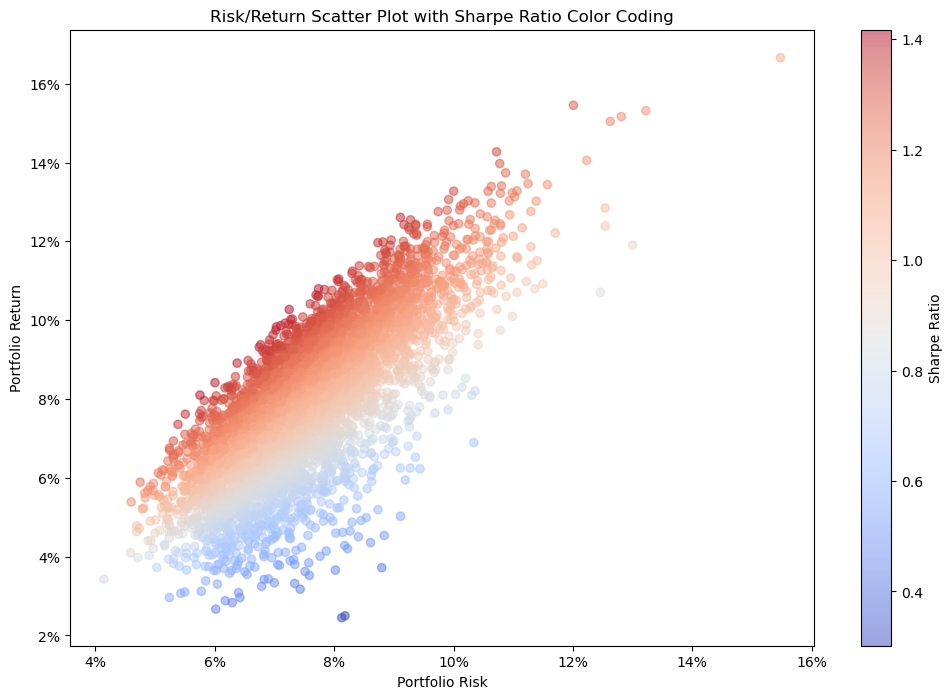

In [101]:
plt.figure(figsize=aspect_ratio)
ax = plt.subplot()
scatter = plt.scatter(portfolio_risks, portfolio_returns, c = pd.DataFrame(np.array(portfolio_returns)/np.array(portfolio_risks)), marker='o', cmap='coolwarm', alpha=0.5)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.title('Risk/Return Scatter Plot with Sharpe Ratio Color Coding')
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Return')
colorbar = plt.colorbar(scatter, label='Sharpe Ratio', cmap='coolwarm')

### Question 9

In [102]:
min_vol_index = np.argmin(portfolio_risks)
max_sharpe_index = np.argmax(np.array(portfolio_returns)/np.array(portfolio_risks))
sharpe_array = np.array(portfolio_returns)/np.array(portfolio_risks)

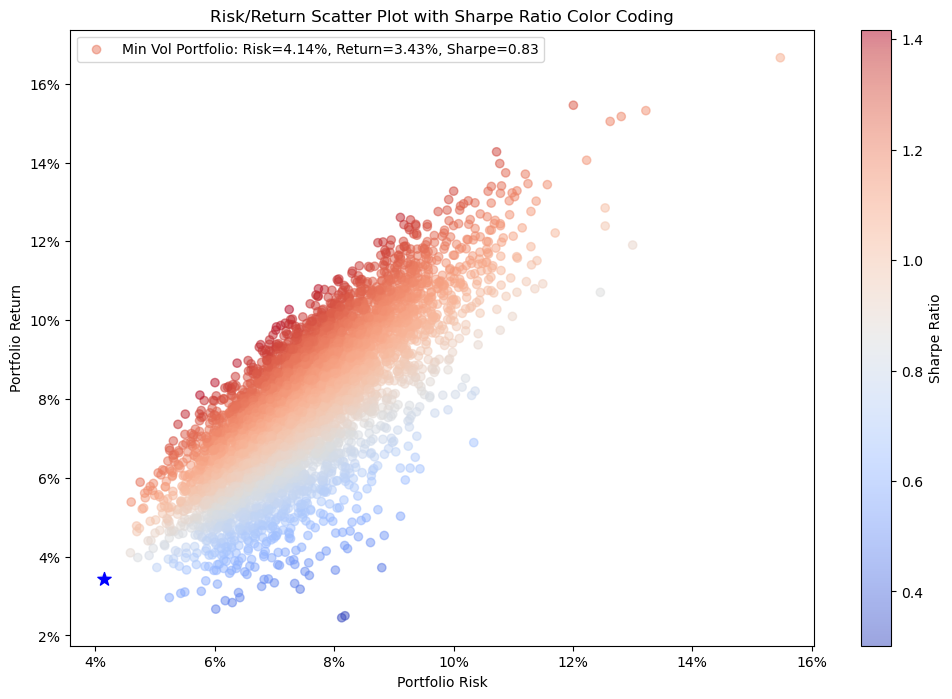

In [103]:
plt.figure(figsize=aspect_ratio)
ax = plt.subplot()
scatter = plt.scatter(portfolio_risks, portfolio_returns, c = pd.DataFrame(np.array(portfolio_returns)/np.array(portfolio_risks)), marker='o', cmap='coolwarm', alpha=0.5)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.title('Risk/Return Scatter Plot with Sharpe Ratio Color Coding')
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Return')
colorbar = plt.colorbar(scatter, label='Sharpe Ratio', cmap='coolwarm')
legend_text = [
    f'Min Vol Portfolio: Risk={portfolio_risks[min_vol_index]:.2%}, Return={portfolio_returns[min_vol_index]:.2%}, Sharpe={sharpe_array[min_vol_index]:.2f}',
    #f'Max Sharpe Portfolio: Risk={portfolio_risks[max_sharpe_index]:.2%}, Return={portfolio_returns[max_sharpe_index]:.2%}, Sharpe={sharpe_array[max_sharpe_index]:.2f}'
]

plt.legend(legend_text)


plt.scatter(portfolio_risks[min_vol_index], portfolio_returns[min_vol_index], marker='*', s=100, color='blue')
#plt.scatter(portfolio_risks[max_sharpe_index], portfolio_returns[max_sharpe_index], marker='*', s=100, color='red')

In [104]:
weights_min_vol = wts_df[np.argmin(portfolio_risks)]

In [105]:
# weights_min_vol = ['AAPL-MAFlat', 'EXC-MAFlat', 'GE-MAFlat', 'PFE-BB', 'SPY-MAFlat', 'VBTIX-MAShort', 'XPT-MAShort', 'GBP-MAShort']


# Creating a horizontal DataFrame
weights_min_vol_df = pd.DataFrame([weights_min_vol], columns=['AAPL-MAFlat', 'EXC-MAFlat', 'GE-MAFlat', 'PFE-BB', 'SPY-MAFlat', 'VBTIX-MAShort', 'XPT-MAShort', 'GBP-MAShort'])


# weights_min_vol_df = pd.DataFrame({'weights_min_vol': weights_min_vol})


In [106]:
weights_min_vol_df

,AAPL-MAFlat,EXC-MAFlat,GE-MAFlat,PFE-BB,SPY-MAFlat,VBTIX-MAShort,XPT-MAShort,GBP-MAShort
0,0.033531,0.065368,0.127068,0.146145,0.04798,0.514682,0.0519,0.013325


Inference:
The portfolio exhibits diversification, with weights spread across multiple assets. Diversification is a risk management strategy that helps reduce exposure to individual asset volatility. The asset with the highest weight is VBTIX-MAShort, suggesting it has the most substantial influence on the portfolio's minimum volatility.While VBTIX-MAShort has the highest weight, the portfolio is diversified, with allocations across various assets. This diversification helps spread risk and minimize the impact of a single asset's poor performance.

### Question 10

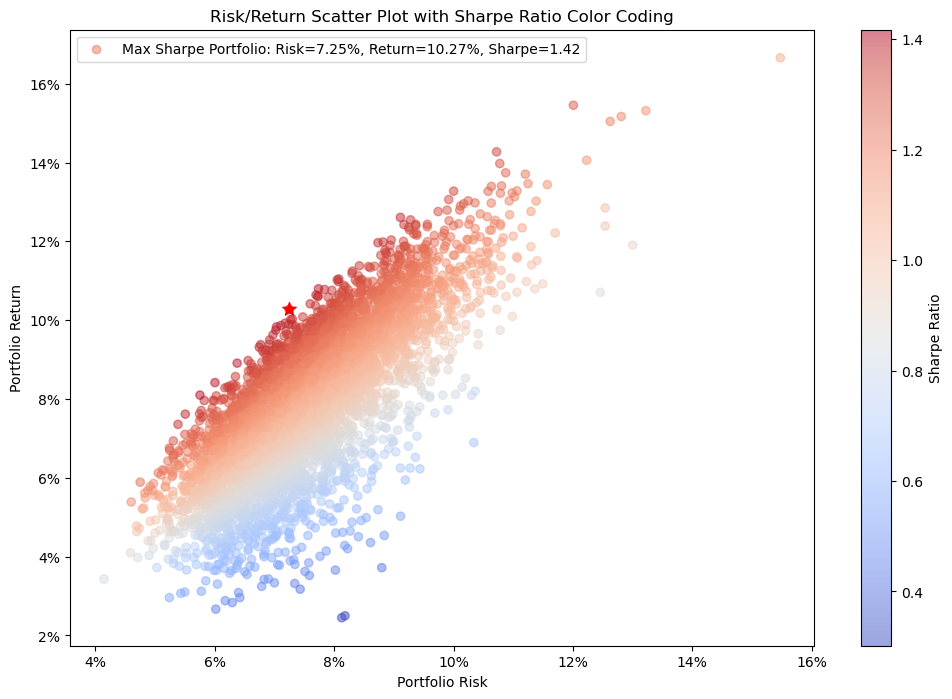

In [107]:
plt.figure(figsize=aspect_ratio)
ax = plt.subplot()
scatter = plt.scatter(portfolio_risks, portfolio_returns, c = pd.DataFrame(np.array(portfolio_returns)/np.array(portfolio_risks)), marker='o', cmap='coolwarm', alpha=0.5)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.title('Risk/Return Scatter Plot with Sharpe Ratio Color Coding')
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Return')
colorbar = plt.colorbar(scatter, label='Sharpe Ratio', cmap='coolwarm')

legend_text = [
    #f'Min Vol Portfolio: Risk={portfolio_risks[min_vol_index]:.2%}, Return={portfolio_returns[min_vol_index]:.2%}, Sharpe={sharpe_array[min_vol_index]:.2f}',
    f'Max Sharpe Portfolio: Risk={portfolio_risks[max_sharpe_index]:.2%}, Return={portfolio_returns[max_sharpe_index]:.2%}, Sharpe={sharpe_array[max_sharpe_index]:.2f}'
]

plt.legend(legend_text)

#plt.scatter(portfolio_risks[min_vol_index], portfolio_returns[min_vol_index], marker='*', s=100, color='blue')
plt.scatter(portfolio_risks[max_sharpe_index], portfolio_returns[max_sharpe_index], marker='*', s=100, color='red')

In [108]:
# wts_max = wts_df[2490]

### Question 11

Yes the Sharpe is Higher

### Question 12

In [109]:
# calculated for the maximum Sharpe ratio portfolio

wts_max = wts_df[max_sharpe_index]

# Calculate the returns of the max Sharpe portfolio
merged_df['MaxSharpe'] = merged_df[myPortfolioColumns].dot(wts_max)

# Display summary statistics
calcSummaryStatistics(merged_df[['MaxSharpe']])

# Compare with individual components
print("\nSummary Statistics of Individual Components:")
for col in myPortfolioColumns:
    print(f"\n{col}:")
    calcSummaryStatistics(merged_df[[col]])


,MaxSharpe
Average Annual Return,10.12%
Annual Risk,7.25%
Success Ratio,53.93%
maxDD,-10.12%


,MaxSharpe
Sharpe Ratio,1.39533



Summary Statistics of Individual Components:

AAPL-MAFlat:


,AAPL-MAFlat
Average Annual Return,27.81%
Annual Risk,27.47%
Success Ratio,65.92%
maxDD,-55.13%


,AAPL-MAFlat
Sharpe Ratio,1.012515



EXC-MAFlat:


,EXC-MAFlat
Average Annual Return,1.70%
Annual Risk,17.15%
Success Ratio,71.03%
maxDD,-67.90%


,EXC-MAFlat
Sharpe Ratio,0.099262



GE-MAFlat:


,GE-MAFlat
Average Annual Return,0.47%
Annual Risk,14.22%
Success Ratio,74.67%
maxDD,-31.17%


,GE-MAFlat
Sharpe Ratio,0.033361



PFE-BB:


,PFE-BB
Average Annual Return,8.16%
Annual Risk,12.93%
Success Ratio,92.59%
maxDD,-24.22%


,PFE-BB
Sharpe Ratio,0.630957



SPY-MAFlat:


,SPY-MAFlat
Average Annual Return,5.46%
Annual Risk,10.58%
Success Ratio,69.56%
maxDD,-19.50%


,SPY-MAFlat
Sharpe Ratio,0.515852



VBTIX-MAShort:


,VBTIX-MAShort
Average Annual Return,0.14%
Annual Risk,3.81%
Success Ratio,59.29%
maxDD,-13.79%


,VBTIX-MAShort
Sharpe Ratio,0.037111



XPT-MAShort:


,XPT-MAShort
Average Annual Return,14.13%
Annual Risk,22.23%
Success Ratio,52.86%
maxDD,-81.65%


,XPT-MAShort
Sharpe Ratio,0.635677



GBP-MAShort:


,GBP-MAShort
Average Annual Return,4.99%
Annual Risk,9.52%
Success Ratio,51.42%
maxDD,-20.72%


,GBP-MAShort
Sharpe Ratio,0.523448


In [110]:
merged_df

,AAPL-MAFlat,EXC-MAFlat,GE-MAFlat,PFE-BB,SPY-MAFlat,VBTIX-MAShort,XPT-MAShort,GBP-MAShort,MaxSharpe
Date,,,,,,,,,
2000-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-01,NaN,NaN,NaN,NaN,NaN,0.005271,0.009116,0.004673,NaN
2000-06-02,NaN,NaN,NaN,NaN,NaN,0.004197,0.016202,-0.010252,NaN
2000-06-05,NaN,NaN,NaN,NaN,NaN,0.003136,0.008889,-0.006470,NaN
2000-06-06,NaN,NaN,NaN,NaN,NaN,0.000000,0.007055,-0.005774,NaN
...,...,...,...,...,...,...,...,...,...
2018-12-24,-0.0,-0.045929,-0.0,0.033466,-0.0,-0.001919,-0.001678,-0.004812,0.005503
2018-12-26,0.0,0.014721,0.0,0.000000,0.0,0.003842,0.014666,-0.005762,0.000414
2018-12-27,-0.0,0.006722,-0.0,0.000000,0.0,-0.000962,-0.000941,0.000870,0.000379


#### Salient Features:

MaxSharpe Portfolio:
Average Annual Return: 10.12%

This is the average yearly gain of your portfolio, which indicates how well your investments performed on average each year.
Annual Risk: 7.25%

This represents the standard deviation of the portfolio's returns, providing a measure of the portfolio's volatility or risk.
Success Ratio: 53.93%

The success ratio is the percentage of positive-return periods, giving an idea of how often the portfolio generates positive returns.
maxDD (Maximum Drawdown): -10.12%

This is the largest percentage decline in the portfolio from a previous peak. In this case, it's a positive value, suggesting a 10.12% decrease from the highest point.
Sharpe Ratio: 1.39533

The Sharpe Ratio measures the risk-adjusted return of the portfolio. A higher Sharpe Ratio generally indicates a better risk-adjusted performance.
Individual Components:
Each individual component of the portfolio (e.g., AAPL-MAFlat, EXC-MAFlat, etc.) has its own set of summary statistics. Here are the key points:

Average Annual Return:

The returns of individual components vary, with AAPL-MAFlat having the highest return (27.81%) and VBTIX-MAShort having the lowest (0.14%).
Annual Risk:

The individual components also have varying levels of risk, with XPT-MAShort having the highest annual risk (22.23%) and VBTIX-MAShort having the lowest (3.81%).
Success Ratio:

Success ratios differ across components, with PFE-BB having the highest (92.59%) and VBTIX-MAShort having the lowest (59.29%).
maxDD (Maximum Drawdown):

Drawdowns vary significantly, with XPT-MAShort experiencing the largest drawdown (-81.65%), indicating a substantial loss at its lowest point.
Sharpe Ratio:

Sharpe Ratios provide a measure of risk-adjusted returns for individual components, with AAPL-MAFlat having the highest (1.012515) and GE-MAFlat having the lowest (0.033361).

#### Overall Comparison:
The MaxSharpe portfolio appears to have a moderate level of risk (7.25%) with a relatively high average annual return (10.12%) and a decent Sharpe Ratio (1.39533).
Individual components show a wide range of performance, risk, and drawdowns.
Diversification and the allocation strategy seem to contribute to achieving a better risk-adjusted return in the overall portfolio compared to individual components.


### Question 13

In [111]:
from sklearn.linear_model import LinearRegression

# Assuming dfPrices contains the prices including the S&P 500 (SPY)
# and merged_df contains the returns of your portfolios, including 'MaxSharpe' and 'SPY-MAFlat'

# Extract relevant columns
returns_data = merged_df[['MaxSharpe', 'SPY-MAFlat']].dropna()

# Separate independent variable (SPY) and dependent variable (MaxSharpe)
X = returns_data[['SPY-MAFlat']]
y = returns_data['MaxSharpe']

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the beta coefficient
beta = model.coef_[0]

print("Beta of the Maximum Sharpe Portfolio to S&P 500:", beta)


Beta of the Maximum Sharpe Portfolio to S&P 500: 0.19409127418819042


Answer:

A beta of 0.1940 indicates that the Maximum Sharpe Portfolio has a relatively lower sensitivity to the S&P 500, providing potential diversification benefits and suggesting a strategy that is less affected by overall market movements. 

### Question 14

##### 14)A

In [112]:
df_ma_AAPL = movingAverageCrossover(dfPrices[['AAPL']].copy(), 11, 220)
df_ma_EXC = movingAverageCrossover(dfPrices[['EXC']].copy(), 11, 220)
df_ma_GE = movingAverageCrossover(dfPrices[['GE']].copy(), 11, 220)
df_ma_PFE = movingAverageCrossover(dfPrices[['PFE']].copy(), 11, 220)
df_ma_SPY = movingAverageCrossover(dfPrices[['SPY']].copy(), 11, 220)
df_ma_FBNDX = movingAverageCrossover(dfPrices[['FBNDX']].copy(), 11, 220)
df_ma_XPT = movingAverageCrossover(dfPrices[['XPT']].copy(), 11, 220)
df_ma_GBP = movingAverageCrossover(dfPrices[['GBP']].copy(), 11, 220)


In [113]:
portfolio_bmk = pd.concat([df_ma_AAPL.drop(columns=['AAPL-MAFlat','AAPL-MAShort']),
                           df_ma_EXC.drop(columns=['EXC-MAFlat','EXC-MAShort']),
                           df_ma_GE.drop(columns=['GE-MAFlat','GE-MAShort']),
                           df_ma_PFE.drop(columns=['PFE-MAFlat','PFE-MAShort']),
                           df_ma_SPY.drop(columns=['SPY-MAFlat','SPY-MAShort']),
                           df_ma_FBNDX.drop(columns=['FBNDX-MAFlat','FBNDX-MAShort']),
                           df_ma_XPT.drop(columns=['XPT-MAFlat','XPT-MAShort']),
                           df_ma_GBP.drop(columns=['GBP-MAFlat','GBP-MAShort'])
                          ], axis=1, join='inner')
portfolio_bmk

,AAPL-BMK,EXC-BMK,GE-BMK,PFE-BMK,SPY-BMK,FBNDX-BMK,XPT-BMK,GBP-BMK
Date,,,,,,,,
2000-11-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-11-13,0.016259,0.006263,-0.046299,-0.044902,-0.007807,0.001430,-0.009368,0.008731
2000-11-14,0.044171,-0.028498,0.025196,0.014706,0.025940,0.001428,0.008368,-0.005020
2000-11-15,-0.018691,0.003207,-0.004751,0.005822,0.003140,0.001426,-0.008368,-0.002660
2000-11-16,-0.045024,0.022165,0.002378,0.005789,-0.015798,0.001423,-0.014048,-0.000982
...,...,...,...,...,...,...,...,...
2018-12-24,-0.026215,-0.045929,-0.032697,-0.033466,-0.026778,0.001303,-0.001678,0.004812
2018-12-26,0.068053,0.014721,0.065712,0.039647,0.049290,-0.003914,0.014666,-0.005762
2018-12-27,-0.006511,0.006722,-0.016371,0.015522,0.007648,-0.002618,-0.000941,0.000870


In [114]:
# Calculate equal weights
num_strategies = 8
weights = np.ones(num_strategies) / num_strategies

# Calculate portfolio returns
portfolio_returns = portfolio_bmk.dot(weights)

# Calculate portfolio volatility (standard deviation)
portfolio_volatility = portfolio_returns.std()

# Calculate annualized Sharpe ratio (assuming 260 trading days in a year)
annualized_sharpe_ratio = np.sqrt(260) * (portfolio_returns.mean() / portfolio_volatility)

print("Annualized Sharpe Ratio of Equal-Weighted BMK Portfolio:", annualized_sharpe_ratio)


Annualized Sharpe Ratio of Equal-Weighted BMK Portfolio: 0.21547002384618022


##### 14)B

In [115]:
portfolio_maflat = pd.concat([df_ma_AAPL.drop(columns=['AAPL-BMK','AAPL-MAShort']),
                           df_ma_EXC.drop(columns=['EXC-BMK','EXC-MAShort']),
                           df_ma_GE.drop(columns=['GE-BMK','GE-MAShort']),
                           df_ma_PFE.drop(columns=['PFE-BMK','PFE-MAShort']),
                           df_ma_SPY.drop(columns=['SPY-BMK','SPY-MAShort']),
                           df_ma_FBNDX.drop(columns=['FBNDX-BMK','FBNDX-MAShort']),
                           df_ma_XPT.drop(columns=['XPT-BMK','XPT-MAShort']),
                           df_ma_GBP.drop(columns=['GBP-BMK','GBP-MAShort'])
                          ], axis=1, join='inner')
portfolio_maflat

,AAPL-MAFlat,EXC-MAFlat,GE-MAFlat,PFE-MAFlat,SPY-MAFlat,FBNDX-MAFlat,XPT-MAFlat,GBP-MAFlat
Date,,,,,,,,
2000-11-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-11-13,0.0,0.006263,-0.046299,-0.044902,-0.0,0.001430,-0.009368,0.0
2000-11-14,0.0,-0.028498,0.025196,0.014706,0.0,0.001428,0.008368,-0.0
2000-11-15,-0.0,0.003207,-0.004751,0.005822,0.0,0.001426,-0.008368,-0.0
2000-11-16,-0.0,0.022165,0.002378,0.005789,-0.0,0.001423,-0.014048,-0.0
...,...,...,...,...,...,...,...,...
2018-12-24,-0.0,-0.045929,-0.000000,-0.033466,-0.0,0.000000,-0.000000,0.0
2018-12-26,0.0,0.014721,0.000000,0.039647,0.0,-0.000000,0.000000,-0.0
2018-12-27,-0.0,0.006722,-0.000000,0.015522,0.0,-0.000000,-0.000000,0.0


In [116]:
# Calculate equal weights
num_strategies = 8
weights = np.ones(num_strategies) / num_strategies

# Calculate portfolio returns
portfolio_returns = portfolio_maflat.dot(weights)

# Calculate portfolio volatility (standard deviation)
portfolio_volatility = portfolio_returns.std()

# Calculate annualized Sharpe ratio (assuming 260 trading days in a year)
annualized_sharpe_ratio = np.sqrt(260) * (portfolio_returns.mean() / portfolio_volatility)

print("Annualized Sharpe Ratio of Equal-Weighted MA-FLAT Portfolio:", annualized_sharpe_ratio)


Annualized Sharpe Ratio of Equal-Weighted MA-FLAT Portfolio: 0.6789428363558484


##### 14)C

In [117]:
portfolio_mashort = pd.concat([df_ma_AAPL.drop(columns=['AAPL-BMK','AAPL-MAFlat']),
                           df_ma_EXC.drop(columns=['EXC-BMK','EXC-MAFlat']),
                           df_ma_GE.drop(columns=['GE-BMK','GE-MAFlat']),
                           df_ma_PFE.drop(columns=['PFE-BMK','PFE-MAFlat']),
                           df_ma_SPY.drop(columns=['SPY-BMK','SPY-MAFlat']),
                           df_ma_FBNDX.drop(columns=['FBNDX-BMK','FBNDX-MAFlat']),
                           df_ma_XPT.drop(columns=['XPT-BMK','XPT-MAFlat']),
                           df_ma_GBP.drop(columns=['GBP-BMK','GBP-MAFlat'])
                          ], axis=1, join='inner')
portfolio_mashort

,AAPL-MAShort,EXC-MAShort,GE-MAShort,PFE-MAShort,SPY-MAShort,FBNDX-MAShort,XPT-MAShort,GBP-MAShort
Date,,,,,,,,
2000-11-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-11-13,-0.016259,0.006263,-0.046299,-0.044902,0.007807,0.001430,-0.009368,-0.008731
2000-11-14,-0.044171,-0.028498,0.025196,0.014706,-0.025940,0.001428,0.008368,0.005020
2000-11-15,0.018691,0.003207,-0.004751,0.005822,-0.003140,0.001426,-0.008368,0.002660
2000-11-16,0.045024,0.022165,0.002378,0.005789,0.015798,0.001423,-0.014048,0.000982
...,...,...,...,...,...,...,...,...
2018-12-24,0.026215,-0.045929,0.032697,-0.033466,0.026778,-0.001303,0.001678,-0.004812
2018-12-26,-0.068053,0.014721,-0.065712,0.039647,-0.049290,0.003914,-0.014666,0.005762
2018-12-27,0.006511,0.006722,0.016371,0.015522,-0.007648,0.002618,0.000941,-0.000870


In [118]:
# Calculate equal weights
num_strategies = 8
weights = np.ones(num_strategies) / num_strategies

# Calculate portfolio returns
portfolio_returns = portfolio_mashort.dot(weights)

# Calculate portfolio volatility (standard deviation)
portfolio_volatility = portfolio_returns.std()

# Calculate annualized Sharpe ratio (assuming 260 trading days in a year)
annualized_sharpe_ratio = np.sqrt(260) * (portfolio_returns.mean() / portfolio_volatility)

print("Annualized Sharpe Ratio of Equal-Weighted MA SHORT Portfolio:", annualized_sharpe_ratio)


Annualized Sharpe Ratio of Equal-Weighted MA SHORT Portfolio: 0.5914867979124263


##### 14)D

In [119]:
df_bb_AAPL = bollingerBands(dfPrices[['AAPL']].copy(), 148, 3)
df_bb_EXC = bollingerBands(dfPrices[['EXC']].copy(), 148, 3)
df_bb_GE = bollingerBands(dfPrices[['GE']].copy(), 148, 3)
df_bb_PFE = bollingerBands(dfPrices[['PFE']].copy(), 148, 3)
df_bb_SPY = bollingerBands(dfPrices[['SPY']].copy(), 148, 3)
df_bb_FBNDX = bollingerBands(dfPrices[['FBNDX']].copy(), 148, 3)
df_bb_XPT = bollingerBands(dfPrices[['XPT']].copy(), 148, 3)
df_bb_GBP = bollingerBands(dfPrices[['GBP']].copy(), 148, 3)


In [120]:
portfolio_bb = pd.concat([df_bb_AAPL.drop(columns=['AAPL-BMK']),
                           df_bb_EXC.drop(columns=['EXC-BMK']),
                           df_bb_GE.drop(columns=['GE-BMK']),
                           df_bb_PFE.drop(columns=['PFE-BMK']),
                           df_bb_SPY.drop(columns=['SPY-BMK']),
                           df_bb_FBNDX.drop(columns=['FBNDX-BMK']),
                           df_bb_XPT.drop(columns=['XPT-BMK']),
                           df_bb_GBP.drop(columns=['GBP-BMK'])
                          ], axis=1, join='inner')
portfolio_bb

,AAPL-BB,EXC-BB,GE-BB,PFE-BB,SPY-BB,FBNDX-BB,XPT-BB,GBP-BB
Date,,,,,,,,
2000-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-02,-0.0,0.0,-0.000000,0.000000,0.000000,0.0,0.0,0.0
2000-08-03,0.0,0.0,0.000000,-0.000000,0.000000,0.0,-0.0,0.0
2000-08-04,-0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2000-08-07,0.0,0.0,-0.000000,-0.000000,0.000000,-0.0,-0.0,0.0
...,...,...,...,...,...,...,...,...
2018-12-24,-0.0,-0.0,-0.032697,0.033466,-0.026778,0.0,-0.0,0.0
2018-12-26,0.0,0.0,0.065712,0.000000,0.049290,-0.0,0.0,-0.0
2018-12-27,-0.0,0.0,-0.016371,0.000000,0.007648,-0.0,-0.0,0.0


In [121]:
# Calculate equal weights
num_strategies = 8
weights = np.ones(num_strategies) / num_strategies

# Calculate portfolio returns
portfolio_returns = portfolio_bb.dot(weights)

# Calculate portfolio volatility (standard deviation)
portfolio_volatility = portfolio_returns.std()

# Calculate annualized Sharpe ratio (assuming 260 trading days in a year)
annualized_sharpe_ratio = np.sqrt(260) * (portfolio_returns.mean() / portfolio_volatility)

print("Annualized Sharpe Ratio of Equal-Weighted BB Portfolio:", annualized_sharpe_ratio)


Annualized Sharpe Ratio of Equal-Weighted BB Portfolio: -0.19934392621954364


#### Answer:

No none of them outperform the Max Sharpe Portfolio

We have used ChatGPT, our previous homework submissions and Professor's Notebooks as references for almost all the questions.

We pledge on our honor that we have not given nor received any unauthorized assistance on this
assignment to/from other groups. Nor have we received any assistance from prior year students.
- Meet Doshi, Udit Singh, Nicole Shammay, Sai Charan, Ruoyi Liu